# Retrieve data from eNanomapper database
https://search.data.enanomapper.net/

- This notebook uses Apache Solr API and AMBIT REST API  (see Swagger interactive documentation at http://enanomapper.github.io/API/ )

In [1]:
import pandas as pd
import os.path
import numpy as np
import datetime, time
import urllib3
import json
import sys
import ipywidgets as widgets
import logging
from logging.config import fileConfig
fileConfig('logging_endpoints_config.ini')

from jaqpotpy import Jaqpot

global logger
logger = logging.getLogger()

%run units.py
#!python units.py

logger.debug('Started at %s \t%s',os.name, datetime.datetime.now())

urllib3.disable_warnings()

In [2]:
%run solrapi.py

In [3]:
%run enmapi.py

In [4]:
http_pool=urllib3.PoolManager()

### Retrieve endpoints using AMBIT REST API

In [5]:
ambit=AMBITQuery(key="study")
print(ambit.root)
data = ambit.get(http_pool)


2020-02-12 16:44:14,152  INFO     Sending query to https://apps.ideaconsult.net/nanoreg1/query/study
2020-02-12 16:44:14,294  INFO     Received response 


https://apps.ideaconsult.net/nanoreg1


In [6]:
#Select endpoint
_sections={}

top_sections = []
for facet in data['facet']:
    #print("{}\t{}\t{}\t{}".format(facet['subcategory'],facet['endpoint'],facet['count'],facet['value']))
    top = facet['subcategory']
    if not top in top_sections:
        top_sections.append(top)
        
    if not top in _sections:
        _sections[top] = []
    
    _sections[top].append(facet['endpoint'])

top_widget = widgets.Dropdown(
    options=top_sections,
    value=top_sections[0],
    description='Select:',
    disabled=False,
)
display(top_widget)


Dropdown(description='Select:', options=('ECOTOX', 'P-CHEM', 'TOX'), value='ECOTOX')

In [7]:
top=top_widget.value
category_widget = widgets.Dropdown(
    options=_sections[top],
    value=_sections[top][1],
    description='Endpoint:',
    disabled=False,
)
display(category_widget)

Dropdown(description='Endpoint:', index=1, options=('EC_ALGAETOX_SECTION', 'EC_DAPHNIATOX_SECTION', 'EC_FISHTO…

#### Setup the query

In [8]:
freetext_widget=widgets.Text(
    value='NM220,NM101,NM103,NM102',
    description='Search',
    disabled=False
)
freetext_widget

Text(value='NM220,NM101,NM103,NM102', description='Search')

In [9]:
materialfilter=freetext_widget.value
if "" == materialfilter:
    materialfilter=None
    
section=category_widget.value
fields=None
if section in _fields:
    fields=_fields[section]

endpoint="*"
if section in _endpoint:
    endpoint=_endpoint[section]
    
settings = {'endpointfilter': ' effectendpoint_s: {}'.format(endpoint),
            'studyfilter': ' topcategory_s:({}) AND endpointcategory_s:({})'.format(top,section),            
            'query_guidance': None, 
            'query_organism': None,
            'fields' : fields
           }
    
logger.info(settings)  
logger.info("Free text query: {}".format(materialfilter))

2020-02-12 16:44:20,963  INFO     {'endpointfilter': ' effectendpoint_s: *', 'studyfilter': ' topcategory_s:(ECOTOX) AND endpointcategory_s:(EC_DAPHNIATOX_SECTION)', 'query_guidance': None, 'query_organism': None, 'fields': None}
2020-02-12 16:44:20,964  INFO     Free text query: NM220,NM101,NM103,NM102


### Run the query

In [11]:

try:
    with open('./config.solr.json') as f:
        solr_services = json.load(f)
except:        
    solr_services = None
    logger.error("Something went wrong")

service_widget = widgets.Dropdown(
    options=solr_services.keys(),
    description='Service:',
    disabled=False,
)
display(service_widget)

name_widget=widgets.Text(
    placeholder='',
    description='User name:',
    disabled=False
)
password_widget = widgets.Password(description='Password:', placeholder='')
display(name_widget)
password_widget

Dropdown(description='Service:', options=('nanoreg1', 'enm'), value='nanoreg1')

Text(value='', description='User name:', placeholder='')

Password(description='Password:', placeholder='')

In [12]:
query=getSolrQuery(settings,url=solr_services[service_widget.value])
rows = []  

#logger.info(settings)
logger.info(query)
rows = sendSolrRequest(settings=settings,http=http_pool,textfilter=materialfilter,query=query,rows=rows,basic_auth="{}:{}".format(name_widget.value,password_widget.value))

2020-02-12 16:44:42,422  INFO     {'url': 'https://solr.ideaconsult.net/solr/nanoreg_shard1_replica1/select', 'fl': 'name_hs,publicname_hs,substanceType_hs,s_uuid_hs,[child parentFilter=filter(type_s:substance) childFilter="filter(type_s:study AND  topcategory_s:(ECOTOX) AND endpointcategory_s:(EC_DAPHNIATOX_SECTION) AND  effectendpoint_s: *)  OR filter(type_s:params AND  topcategory_s:(ECOTOX) AND endpointcategory_s:(EC_DAPHNIATOX_SECTION))  OR filter(type_s:conditions AND  topcategory_s:(ECOTOX) AND endpointcategory_s:(EC_DAPHNIATOX_SECTION)) OR filter(type_s:composition AND component_s:CONSTITUENT)" limit=10000]', 'fq': '', 'q': '{!parent which=type_s:substance}'}
2020-02-12 16:44:42,425  INFO     Sending query to https://solr.ideaconsult.net/solr/nanoreg_shard1_replica1/select
2020-02-12 16:44:42,579  INFO     {
  "name_hs": "NM-100 (TiO2 50-150 nm)",
  "publicname_hs": "JRCNM01000a",
  "substanceType_hs": "NPO_1486",
  "s_uuid_hs": "NNRG-18280a4a-45e9-adc0-df3b-125397b1255f"
}


In [13]:
#print("Substances: {}".format(len(rows)))
df = pd.DataFrame(rows)
df.to_csv(section+".nosmiles.txt",sep='\t',index=False)
#df.head()
df.head()

,public.name,r.purposeFlag,r.reliability,r.studyResultType,substance.name,substance.type,substance.uuid,value.endpoint,value.lo,value.qualifier.lo,...,x.params.MEDIUM.ionictrength_d,x.params.MEDIUM.ph_LOQUALIFIER,x.params.MEDIUM.ph_LOVALUE_d,x.params.MEDIUM.ph_UPQUALIFIER,x.params.MEDIUM.ph_UPVALUE_d,x.params.MEDIUM.temperature_UNIT,x.params.MEDIUM.temperature_d,x.params.Vial,x.params.guidance,x.reference_year
0,JRCNM01001a,,None,Measured,NM-101 (TiO2 6 nm),NPO_1486,NNRG-a51b2e58-4105-9643-3016-3f4b431171e2,L.L. (LOWER LIMIT),32.32,,...,884.0,NaN,NaN,NaN,NaN,Celsius,22.0,JRCNM01001a990498,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,2016
1,JRCNM01001a,,None,Measured,NM-101 (TiO2 6 nm),NPO_1486,NNRG-a51b2e58-4105-9643-3016-3f4b431171e2,U.L. (UPPER LIMIT),106.03,,...,884.0,NaN,NaN,NaN,NaN,Celsius,22.0,JRCNM01001a990498,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,2016
2,JRCNM01001a,,None,Measured,NM-101 (TiO2 6 nm),NPO_1486,NNRG-a51b2e58-4105-9643-3016-3f4b431171e2,LC20,61.20,,...,884.0,NaN,NaN,NaN,NaN,Celsius,22.0,JRCNM01001a990498,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,2016
3,JRCNM01001a,,None,Measured,NM-101 (TiO2 6 nm),NPO_1486,NNRG-a51b2e58-4105-9643-3016-3f4b431171e2,L.L. (LOWER LIMIT),89.32,,...,884.0,NaN,NaN,NaN,NaN,Celsius,22.0,JRCNM01001a990498,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,2016
4,JRCNM01001a,,None,Measured,NM-101 (TiO2 6 nm),NPO_1486,NNRG-a51b2e58-4105-9643-3016-3f4b431171e2,U.L. (UPPER LIMIT),281.47,,...,884.0,NaN,NaN,NaN,NaN,Celsius,22.0,JRCNM01001a990498,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,2016


In [14]:
import numpy as np
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

for criteria in ["value.lo"]:
    tmp = pd.pivot_table(df, values=criteria, index=['public.name'], columns=['x.oht.top','x.oht.section','x.guidance','value.endpoint','value.qualifier.lo','value.unit'], aggfunc=np.mean).reset_index()
    #tmp.style.highlight_null(null_color='red')
    
    display(tmp.style.apply(highlight_max,subset=top_sections))

In [15]:
tmp=df.groupby(by=["public.name","x.guidance","value.endpoint","value.qualifier.lo","value.unit"]).agg({"value.lo" : ["min","max","mean","std","count"]}).reset_index()
tmp.columns = ["_".join(x) for x in tmp.columns.ravel()]
print("Substances {}".format(tmp.shape[0]))
display(tmp)


Substances 12


,public.name_,x.guidance_,value.endpoint_,value.qualifier.lo_,value.unit_,value.lo_min,value.lo_max,value.lo_mean,value.lo_std,value.lo_count
0,JRCNM01000a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC20 (48H),,mg/l,100.00,100.00,100.00,0.000000,3
1,JRCNM01000a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC20 (72H),,mg/l,100.00,100.00,100.00,0.000000,3
2,JRCNM01000a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC50 (48H),,mg/l,100.00,100.00,100.00,0.000000,3
3,JRCNM01000a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC50 (72H),,mg/l,100.00,100.00,100.00,0.000000,3
4,JRCNM01001a,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,L.L. (LOWER LIMIT),,mg/l,32.32,89.32,60.82,40.305087,2
5,JRCNM01001a,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,LC20,,,61.20,61.20,61.20,NaN,1
6,JRCNM01001a,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,LC50,,,131.14,131.14,131.14,NaN,1
7,JRCNM01001a,SOP-TOXICITY TEST WITH DAPHNIA MAGNA (WITHOUT ...,U.L. (UPPER LIMIT),,mg/l,106.03,281.47,193.75,124.054814,2
8,JRCNM01003a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC20 (48H),,mg/l,103.90,103.90,103.90,0.000000,3
9,JRCNM01003a,SOP-TOXICITY TEST WITH MICROALGAE P.SUBCAPITAT...,EC20 (72H),,mg/l,3.58,3.58,3.58,0.000000,3


In [16]:
#Communication with Jaqpot
#pip install git+https://github.com/KinkyDesign/jaqpotpy.git


jaqpot = Jaqpot("http://api.jaqpot.org/jaqpot/services/")
jaqpot.request_key("guest", "guest")
jaqpot.upload_dataset(df=tmp, title="Nanoreg Substances", description="Descriptors derived from Nanoreg Substances")

Dataset created with id: ERR7a53bb950e3b41f7a632b5c052c18a3f


In [17]:
%load_ext rpy2.ipython

In [18]:
%R require(ggplot2)

2020-02-12 16:45:01,299  WARNING  R[write to console]: Loading required package: ggplot2



array([1], dtype=int32)

 [1] "EC20 (48H)"         "EC20 (72H)"         "EC50 (48H)"        
 [4] "EC50 (72H)"         "L.L. (LOWER LIMIT)" "LC20"              
 [7] "LC50"               "U.L. (UPPER LIMIT)" "EC20 (48H)"        
[10] "EC20 (72H)"         "EC50 (48H)"         "EC50 (72H)"        
   value.lo_min value.lo_max value.lo_mean value.lo_std value.lo_count
2        100.00       100.00        100.00            0              3
3        100.00       100.00        100.00            0              3
10      1399.00      1399.00       1399.00            0              3
11        22.26        22.26         22.26            0              3


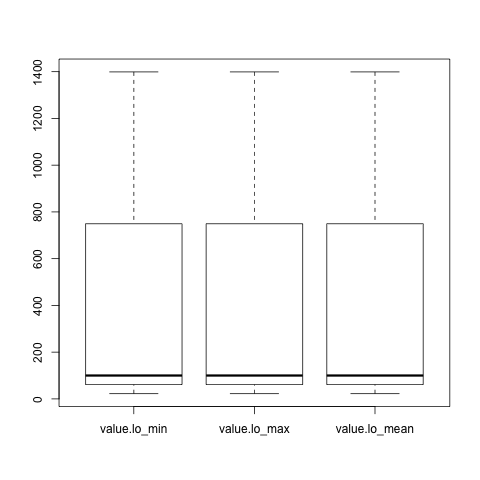

In [19]:
%%R -i tmp

print(tmp[,3])
#https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.z0gxLNc
name1 = strsplit(tmp[,3],' ')
name2 = sapply(name1,function(x)x[[1]][1])

name3 = which(name2 %in% 'EC50')
tmp.sel <- tmp[name3,6:10]
               
print(tmp.sel)

tmp.sel0 <- tmp.sel[,-c(4:5)]
boxplot(tmp.sel0)

In [20]:
#import rpy2.robjects as robjects
#from rpy2.robjects.packages import importr
#base = importr('base')
## evaluate locally a remote R script
#base.source("http://www.bioconductor.org/biocLite.R")
#bioclite = robjects.globalenv['biocLite']

## download and install a bioconductor package
#bioclite("org.Hs.eg.db")

from rpy2.robjects.packages import importr

# do the following _only the first time_, to install the package seqLogo
base = importr('base')
base.source("http://www.bioconductor.org/biocLite.R")
biocinstaller = importr("BiocInstaller")
biocinstaller.biocLite("seqLogo")

# load the installed package "seqLogo"
seqlogo = importr("seqLogo")
biocinstaller.bioclite("org.Hs.eg.db")

2020-02-12 16:45:08,340  WARNING  R[write to console]: Error: With R version 3.5 or greater, install Bioconductor packages using BiocManager; see https://bioconductor.org/install



RRuntimeError: Error: With R version 3.5 or greater, install Bioconductor packages using BiocManager; see https://bioconductor.org/install
